# Решение систем нелинейных уравнений

## Введение

Данная работа посвящена исследованию следующих численных методов 
решения систем нелинейных уравнений:

0. Половинное деление
1. Метод простой итерации (МПИ)
2. Метод Ньютона

## Методология

Исследовать будем на примере 2 нелинейных уравнений (IV.12.3 (а), (м)) и 2 нелинейных систем
(IV.12.4 (a), IV.12.6 (а)).

Примечание: номера взяты из практикума.

## Исследование

In [236]:
import math
import numpy as np


def stop_crit(x_new, x_old, tol=1e-8):
  return np.linalg.norm(np.array(x_new) - np.array(x_old), ord=np.inf) < tol

In [237]:
def bisection(f, a, b, tol=1e-8, maxiter=100):
  fa, fb = f(a), f(b)
  if fa * fb > 0:
    raise ValueError("На концах отрезка нет перемены знака")

  history = []
  for i in range(maxiter):
    c = 0.5 * (a + b)
    fc = f(c)
    history.append(c)
    if abs(fc) < tol or (b - a) / 2 < tol:
      return c, history
    if fa * fc <= 0:
      b, fb = c, fc
    else:
      a, fa = c, fc
  return 0.5 * (a + b), history

In [238]:
def fixed_point_scalar(phi, x0, tol=1e-8, maxiter=200):
  x = x0
  history = [x]
  for k in range(maxiter):
    x_new = phi(x)
    history.append(x_new)
    if abs(x_new - x) < tol:
      return x_new, k + 1
    x = x_new
  return x, history

In [239]:
def newton_scalar(f, df, x0, tol=1e-10, maxiter=100):
  x = x0
  history = [x]
  for k in range(maxiter):
    fx = f(x)
    dfx = df(x)
    if dfx == 0:
      raise ZeroDivisionError("Производная равна нулю")
    x_new = x - fx / dfx
    history.append(x_new)
    if abs(x_new - x) < tol:
      return x_new, history
    x = x_new
  return x, history

In [240]:
def gaussian_elimination(A, b, eps=1e-15):
  n = len(A)
  M = [row[:] for row in A]
  bb = b[:]
  for k in range(n):
    piv = k
    maxv = abs(M[k][k])
    for i in range(k + 1, n):
      if abs(M[i][k]) > maxv:
        maxv = abs(M[i][k])
        piv = i
    if maxv < eps:
      raise ValueError("Cистема вырождена или плохо обусловлена.")
    if piv != k:
      M[k], M[piv] = M[piv], M[k]
      bb[k], bb[piv] = bb[piv], bb[k]
    for i in range(k + 1, n):
      factor = M[i][k] / M[k][k]
      for j in range(k, n):
        M[i][j] -= factor * M[k][j]
      bb[i] -= factor * bb[k]
  x = [0.0] * n
  for i in range(n - 1, -1, -1):
    s = bb[i]
    for j in range(i + 1, n):
      s -= M[i][j] * x[j]
    x[i] = s / M[i][i]
  return x

In [241]:
def newton_system(F, J, x0, tol=1e-10, maxiter=50):
  x = np.array(x0, dtype=float)
  history_x = [x]
  history_res = [np.linalg.norm(F(x), ord=2)]
  for k in range(maxiter):
    Fx = np.array(F(x))
    Jx = np.array(J(x))
    s = gaussian_elimination(Jx, -Fx)
    x_new = x + s
    history_x.append(x)
    history_res.append(np.linalg.norm(F(x), ord=2))
    if stop_crit(x_new, x, tol):
      return x_new, history_x, history_res
    x = x_new
  return x, history_x, history_res

In [242]:
def fixed_point_system(Phi, x0, tol=1e-8, maxiter=500):
  x = np.array(x0, dtype=float)
  history_x = [x0]
  history_res = []
  for k in range(maxiter):
    x_new = np.array(Phi(x))
    history_x.append(x)
    history_res.append(np.linalg.norm(x_new - x, ord=2))
    if stop_crit(x_new, x, tol):
      return x_new, history_x, history_res
    x = x_new
  return x, history_x, history_res

In [243]:
from matplotlib import pyplot as plt


def plot_history(history, x_ref=None, title_prefix=""):
  xs = history
  iters = np.arange(len(xs))
  if x_ref is None:
    x_ref = xs[-1]
  errors = [np.linalg.norm(x - x_ref) for x in xs]

  # Заменяем нули и слишком маленькие значения на безопасный порог для лог-шкалы
  eps = 1e-16
  errors_plot = np.clip(errors, a_min=eps, a_max=None)

  plt.figure(figsize=(16, 8))
  plt.bar(iters, errors_plot, color='red', width=0.6)
  plt.yscale('log')
  plt.title(title_prefix + " $||x_n - x^*||$ по итерациям (гистограмма)")
  plt.xlabel("Итерация")
  plt.ylabel("$||x_n - x^*||$")

  plt.tight_layout()


### IV.12.3 (a)  
$2x^2 + 5x - 3 = 0$

Найденные отрезки с переменой знака: [(np.float64(-3.0199999999999996), np.float64(-3.0)), (np.float64(-3.0), np.float64(-2.9799999999999995)), (np.float64(0.4800000000000004), np.float64(0.5)), (np.float64(0.5), np.float64(0.5199999999999996))]
Бисекция: -3.000000000000582
Ньютон (от бисекционного приближения): -3.0


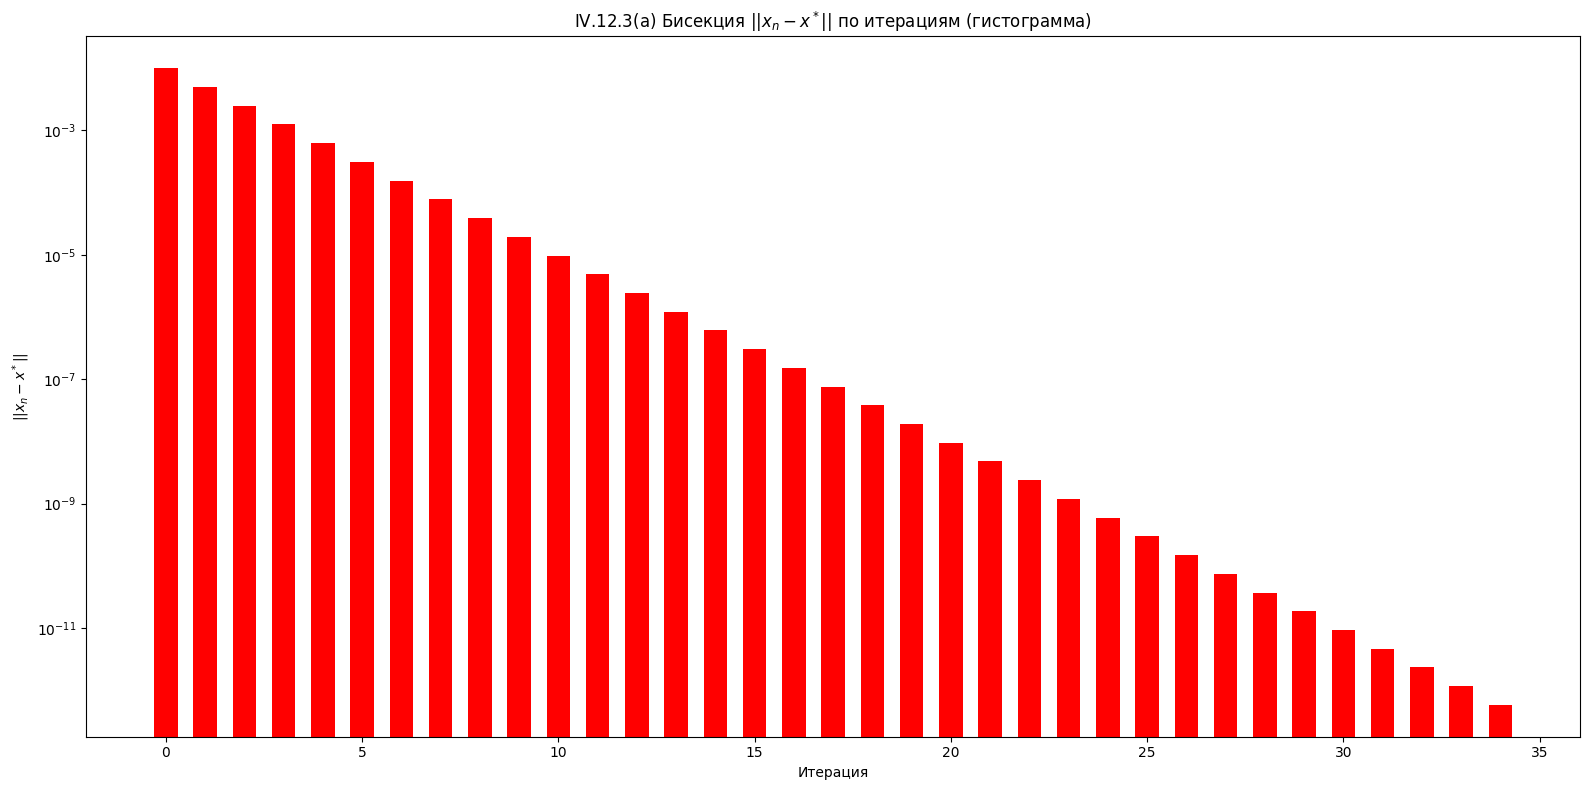

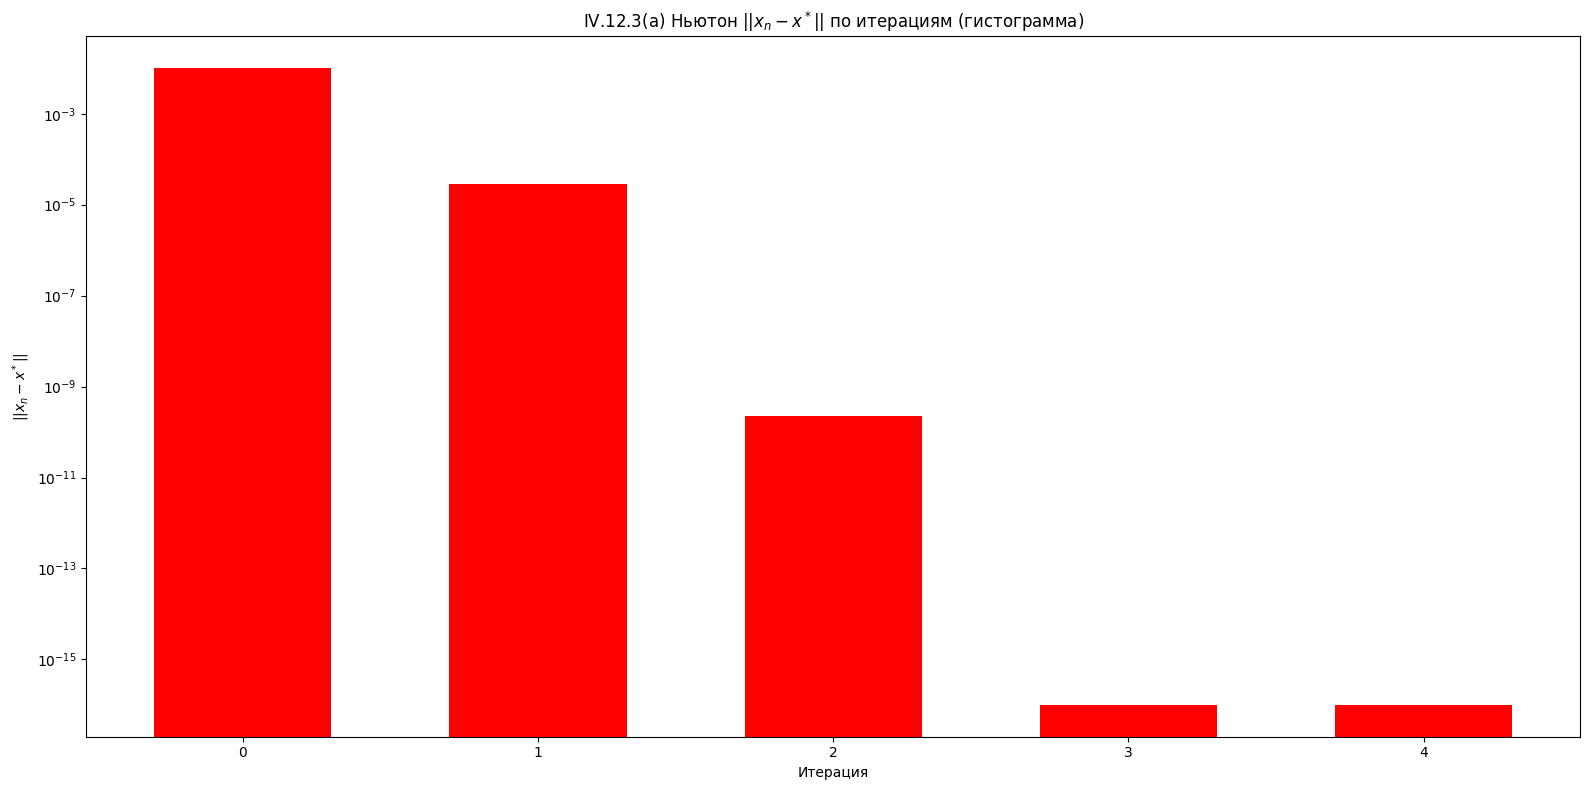

In [244]:
def f_a(x):
  return 2 * x**2 + 5 * x - 3


def df_a(x):
  return 4 * x + 5


# локализуем корни (для квадратного уравнения аналитически известны два корня, но покажем численно)
# используем бисекцию: нужно отрезки с разными знаками
# просканируем сетку для поиска интервалов перемены знака
xs = np.linspace(-10, 10, 1001)
brackets = []
for i in range(len(xs) - 1):
  if f_a(xs[i]) * f_a(xs[i + 1]) <= 0:
    brackets.append((xs[i], xs[i + 1]))
brackets = list(dict.fromkeys(brackets))  # убрать дубли
print("Найденные отрезки с переменой знака:", brackets)

# применим бисекцию к первому интервалу, затем Ньютона
if brackets:
  a, b = brackets[0]
  root_bis, hist_bis = bisection(f_a, a, b, tol=1e-12)
  root_newt, hist_newt = newton_scalar(f_a, df_a, (a + b) / 2.0)
  print("Бисекция:", root_bis)
  print("Ньютон (от бисекционного приближения):", root_newt)

  plot_history(hist_bis, x_ref=root_newt, title_prefix="IV.12.3(a) Бисекция")
  plot_history(hist_newt, x_ref=root_newt, title_prefix="IV.12.3(a) Ньютон")
else:
  print("Не найдены интервалы для бисекции.")

### IV.12.3 (г)  
$(x-3)\cos x = 1$ на отрезке $[-2\pi, 2\pi]$

Интервалы с переменой знака (часть): [(np.float64(-4.580442088933919), np.float64(-4.5741589036267385)), (np.float64(-1.7844246272390025), np.float64(-1.7781414419318224)), (np.float64(5.1836278784231595), np.float64(5.189911063730339))]
Корень -4.580078524377426 (бисекция итераций: [np.float64(-4.577300496280328), np.float64(-4.578871292607124), np.float64(-4.579656690770522), np.float64(-4.5800493898522205), np.float64(-4.580245739393069), np.float64(-4.580147564622645), np.float64(-4.580098477237433), np.float64(-4.580073933544827), np.float64(-4.5800862053911295), np.float64(-4.580080069467979), np.float64(-4.580077001506403), np.float64(-4.580078535487191), np.float64(-4.580077768496797), np.float64(-4.580078151991994), np.float64(-4.580078343739593), np.float64(-4.580078439613391), np.float64(-4.580078487550291), np.float64(-4.580078511518741), np.float64(-4.580078523502966), np.float64(-4.580078529495078), np.float64(-4.5800785264990225), np.float64(-4.580078525000994), np.float

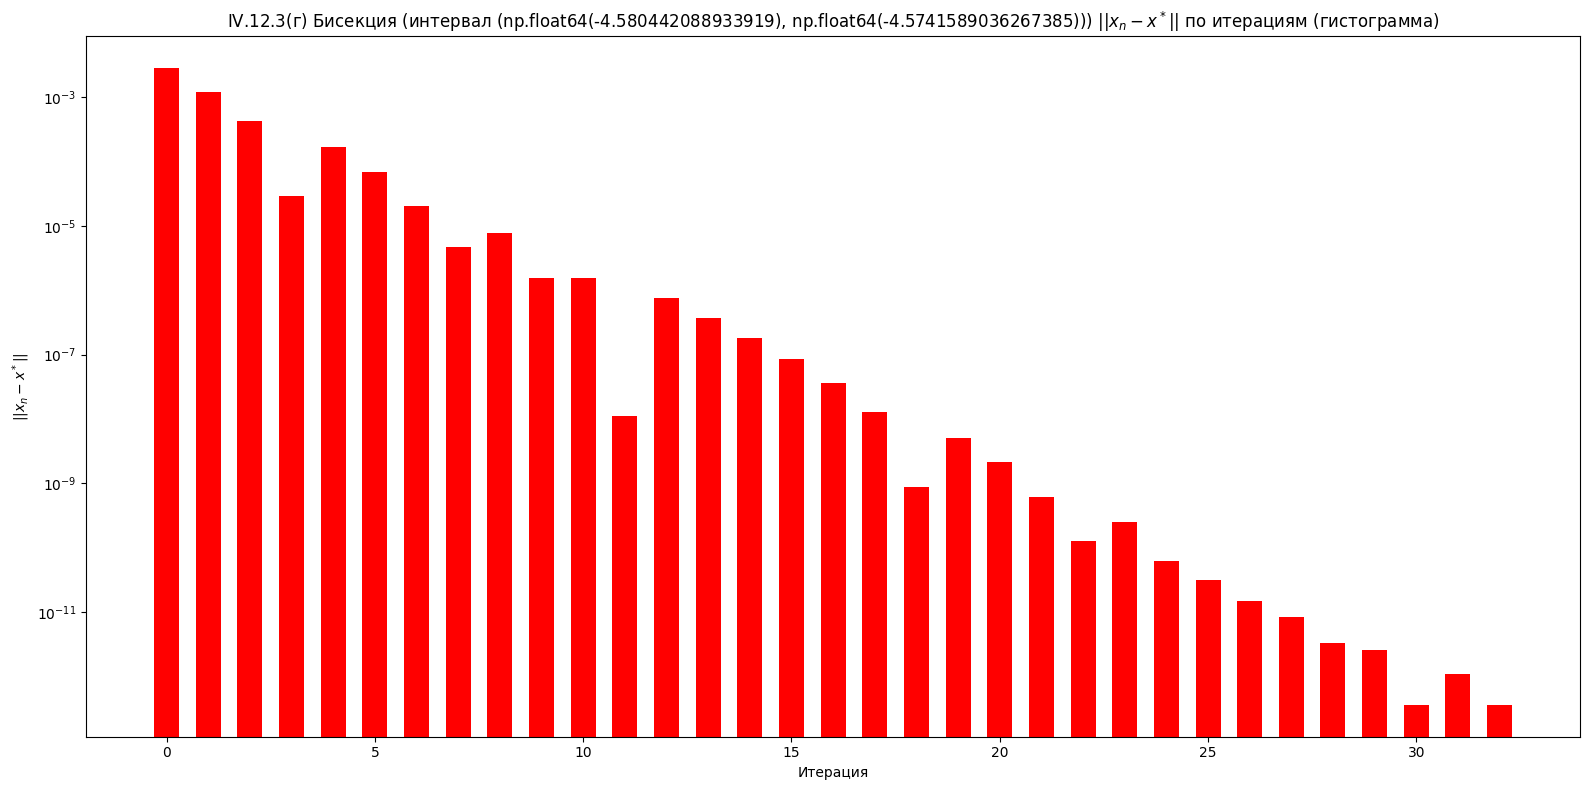

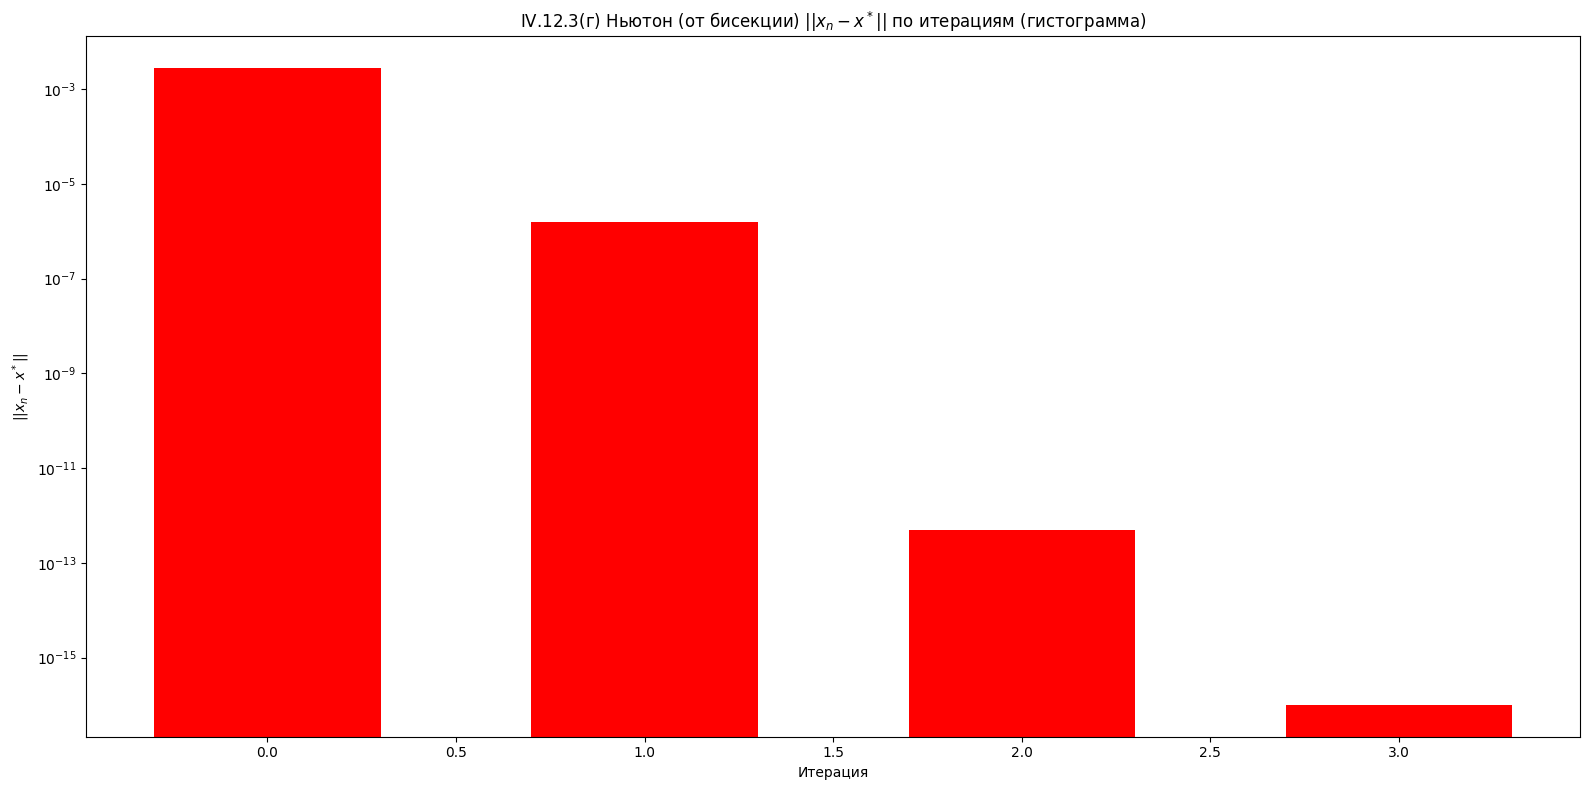

In [ ]:
def f_g(x):
  return (x - 3) * math.cos(x) - 1


# найдём интервалы перемены знака на сетке
xs = np.linspace(-2 * math.pi, 2 * math.pi, 2001)
brackets = []
for i in range(len(xs) - 1):
  if f_g(xs[i]) * f_g(xs[i + 1]) <= 0:
    brackets.append((xs[i], xs[i + 1]))
print("Интервалы с переменой знака (часть):", brackets[:10])


def df_g(x):
  return math.cos(x) - (x - 3) * math.sin(x)


roots = []
for a, b in brackets:
  r_bis, ib = bisection(f_g, a, b, tol=1e-12, maxiter=200)
  r_newt, inewt = newton_scalar(f_g,
                                df_g, (a + b) / 2.0,
                                tol=1e-12,
                                maxiter=200)
  roots.append((r_newt, ib, inewt, (a, b)))

# Выберем первый корень для иллюстрации (если есть)
if roots:
  rn, h_b, h_n, seg = roots[0]
  plot_history(h_b,
               x_ref=rn,
               title_prefix=f"IV.12.3(г) Бисекция (интервал {seg})")
  plot_history(h_n, x_ref=rn, title_prefix="IV.12.3(г) Ньютон")

unique = sorted({round(r[0], 12): r
                 for r in roots}.values(),
                key=lambda x: x[0])
for r, ib, inewt, _ in unique:
  print(f"Корень {r} (бисекция итераций: {ib}, Ньютон: {inewt})")

### IV.12.4 (a)
$\begin{cases} 
\sin(x+1) - y = 1.2\\
2x + \cos(y) = 2
\end{cases}$


IV.12.4 (a) — решение методом Ньютона: [ 0.51015016 -0.20183842]
IV.12.4 (a) — решение методом простой итерации: [ 0.51015016 -0.20183842]


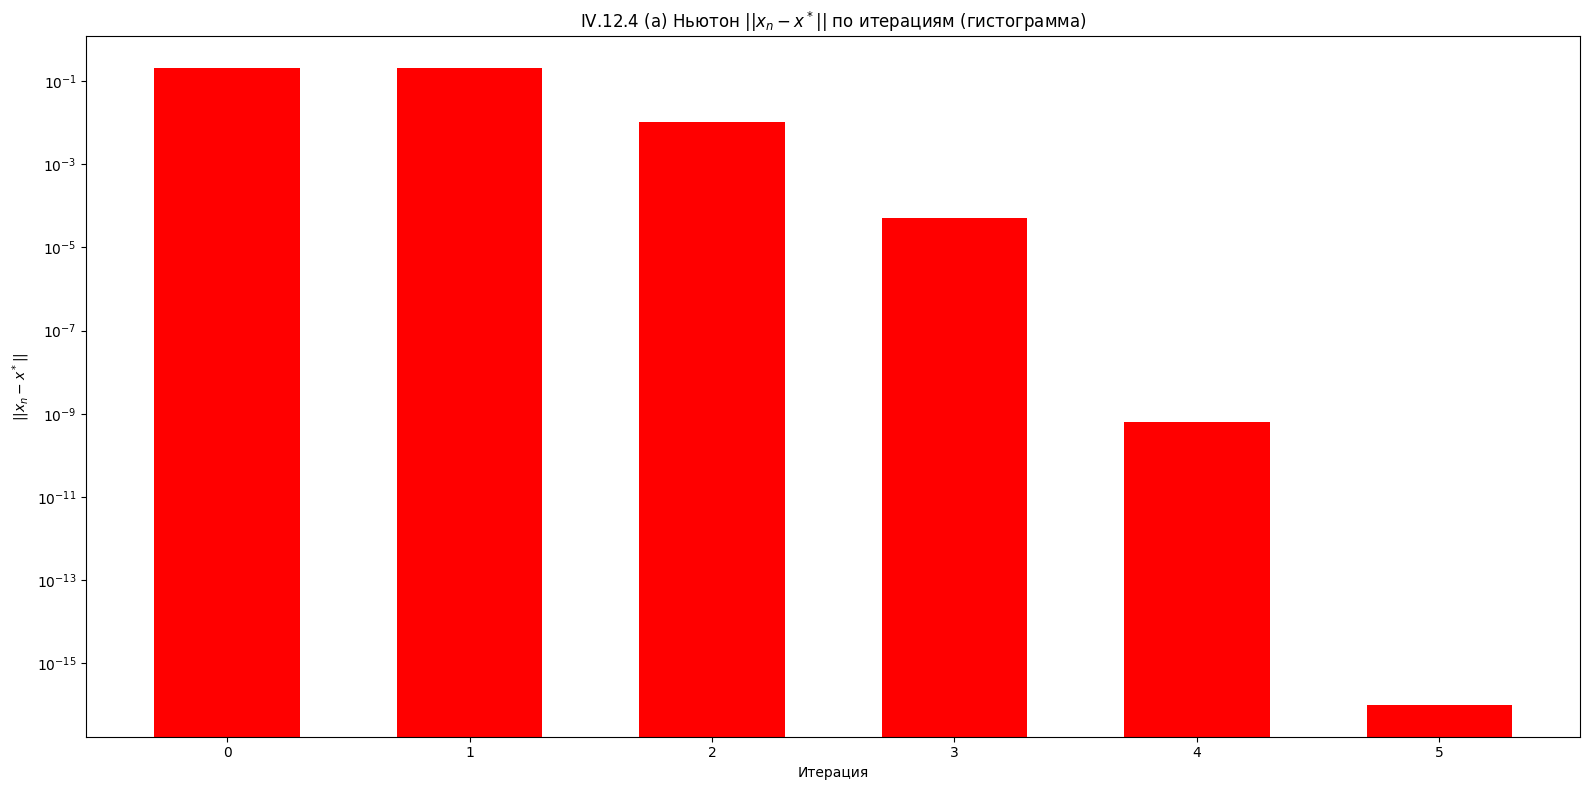

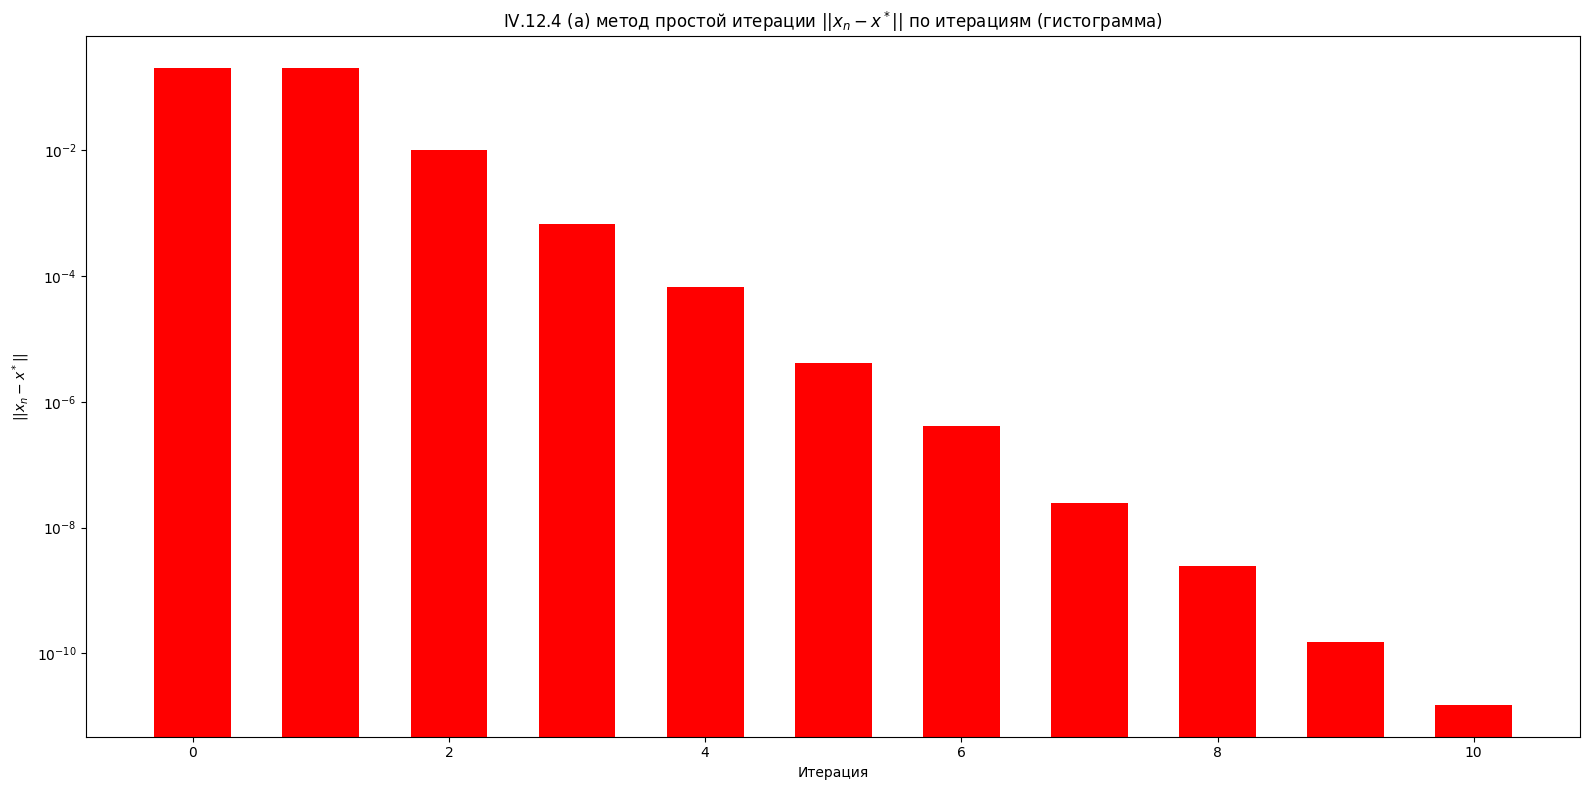

In [246]:
def F_124a(vec):
  x, y = vec
  return np.array([math.sin(x + 1) - y - 1.2, 2 * x + math.cos(y) - 2])


# Якобиан:
def J_124a(vec):
  x, y = vec
  return np.array([[math.cos(x + 1), -1.0], [2.0, -math.sin(y)]])


# Метод Ньютона:
x0 = np.array([0.5, 0.0])  # начальное приближение (наугад)
sol_newton, hist_newt, _ = newton_system(F_124a, J_124a, x0, tol=1e-12)
print("\nIV.12.4 (a) — решение методом Ньютона:", sol_newton)
plot_history(hist_newt, sol_newton, "IV.12.4 (a) Ньютон")


def Phi_124a(vec):
  x, y = vec
  y_new = math.sin(x + 1) - 1.2
  x_new = (2 - math.cos(y)) / 2.0
  return np.array([x_new, y_new])


sol_fix, hist_fix, _ = fixed_point_system(Phi_124a, x0, tol=1e-10, maxiter=500)
print("IV.12.4 (a) — решение методом простой итерации:", sol_fix)
plot_history(hist_fix, sol_fix, "IV.12.4 (a) метод простой итерации")

### IV.12.6 (a)
$\begin{cases}
2x^2 - xy - 5x + 1 = 0\\
x + 3 \lg(x) - y^2 = 0
\end{cases}$

IV.12.6 (a) решение методом Ньютона:
[3.48744279 2.26162863] 10


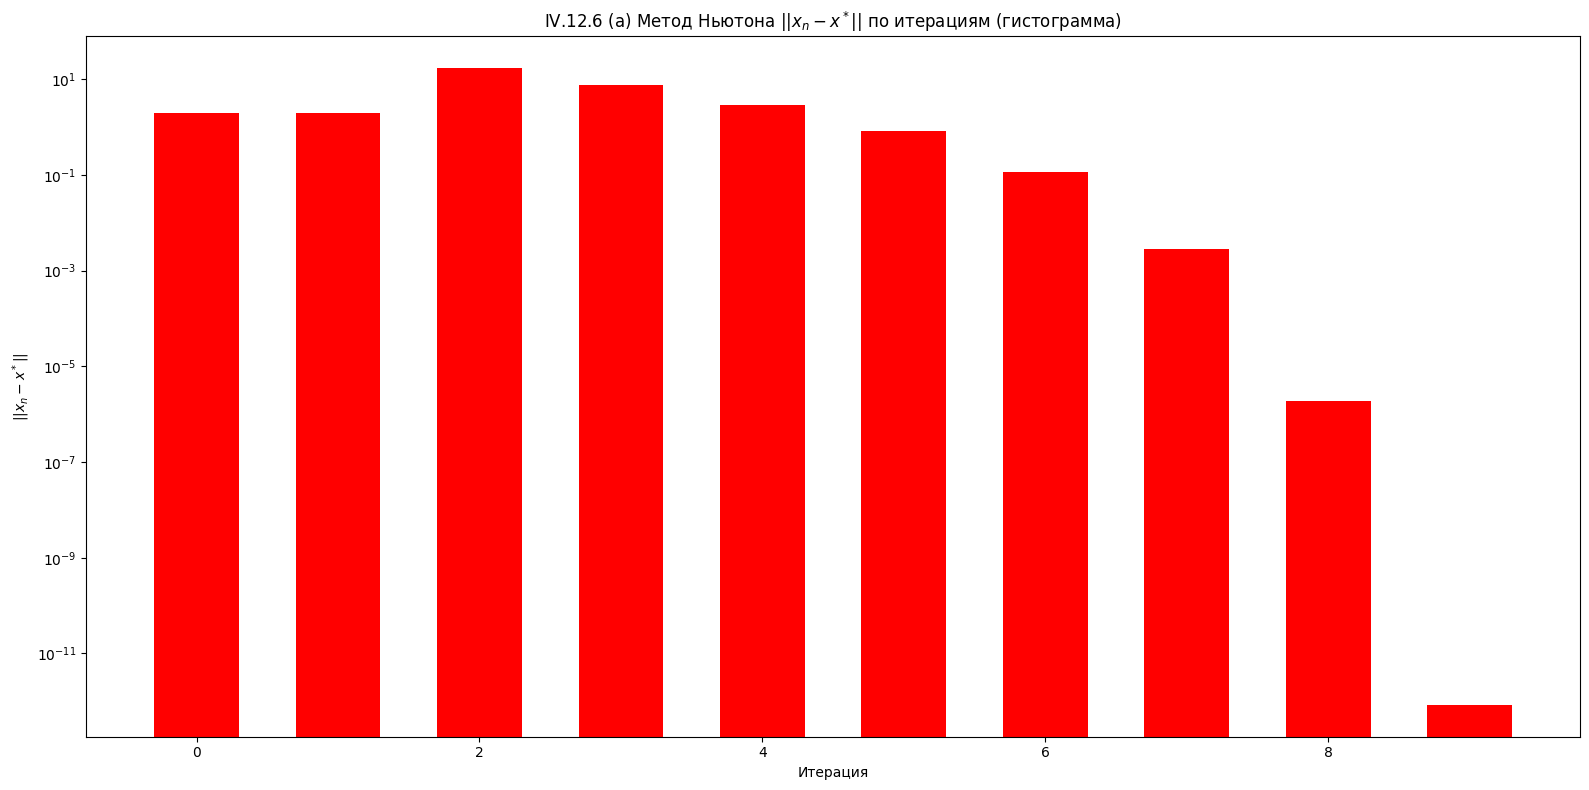

In [247]:
def F_126a(vec):
  x, y = vec
  return np.array([2 * x**2 - x * y - 5 * x + 1, x + 3 * math.log10(x) - y**2])


def J_126a(vec):
  x, y = vec
  return np.array([[4 * x - y - 5, -x], [1 + 3 / (x * math.log(10)), -2 * y]])


starts = [np.array([2.0, 1.0])]
solutions = []
for s in starts:
  sol, hist_newt, _ = newton_system(F_126a, J_126a, s, tol=1e-12, maxiter=80)
  solutions.append((sol, len(hist_newt)))
  plot_history(hist_newt, sol, "IV.12.6 (a) Метод Ньютона")

print("IV.12.6 (a) решение методом Ньютона:")
for sol, it in solutions:
  print(sol, it)